# Experimenting with PSF Deconvolution

In [1]:
import os
import numpy as np
from astropy.units import Quantity, pix, deg, kpc
from matplotlib import pyplot as plt
from astropy.visualization import LogStretch, MinMaxInterval, ImageNormalize, \
AsinhStretch, SqrtStretch, SquaredStretch, LinearStretch
from skimage import restoration
from copy import deepcopy
from scipy.signal import convolve
from matplotlib.ticker import ScalarFormatter, FuncFormatter

from xga.products import Image, ExpMap, PSF, RateMap
from xga.imagetools import radial_brightness, pizza_brightness
from xga.sourcetools import ang_to_rad, rad_to_ang

Assembling list of ObsID pointings: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


## First I'll try with a random bright point source

### Loading in images and PSFs, resampling PSFs to match images

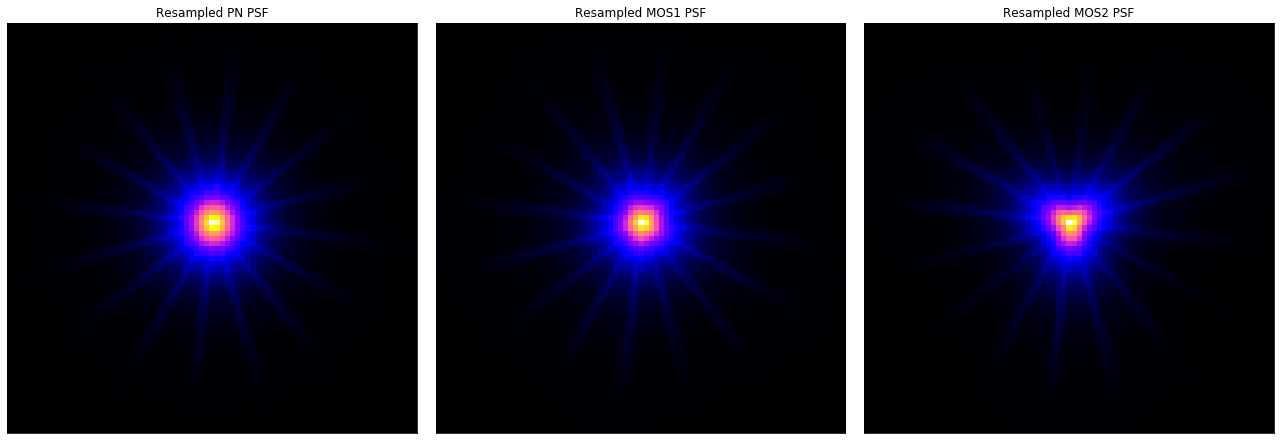

In [2]:
l = Quantity(0.5, "keV")
u = Quantity(2.0, "keV")

#--------------------------------Random Bright Point Source------------------------------------#
# Will be useful for coordinate conversion
# Loading in PN image and PSF
pointy_pn_im = Image("0008220201_pn_exp1-0.50-2.00keVimg.fits", "0008220201", "pn", "", "", "", l, u)
# Should be working with ratemaps really, they have more physical meaning than straight images
pointy_pn_ex = ExpMap("0008220201_pn_exp1-0.50-2.00keVexpmap.fits", "0008220201", "pn", "", "", "", l, u)
pointy_pn_rt = RateMap(pointy_pn_im, pointy_pn_ex)
pointy_pn_psf = PSF("pn_pointy_psf_1250.fits", "ELLBETA", "0008220201", "pn", "", "", "")
# Resamples the PSF array to match the image
pointy_pn_new_psf = pointy_pn_psf.resample(pointy_pn_im, Quantity(256, 'pix'))

# Loading in MOS1 image and PSF
pointy_mos1_im = Image("0008220201_mos1_exp1-0.50-2.00keVimg.fits", "0008220201", "mos1", "", "", "", l, u)
pointy_mos1_ex = ExpMap("0008220201_mos1_exp1-0.50-2.00keVexpmap.fits", "0008220201", "mos1", "", "", "", l, u)
pointy_mos1_rt = RateMap(pointy_mos1_im, pointy_mos1_ex)
pointy_mos1_psf = PSF("mos1_pointy_psf_1250.fits", "ELLBETA", "0008220201", "mos1", "", "", "")
pointy_mos1_new_psf = pointy_mos1_psf.resample(pointy_mos1_im, Quantity(256, 'pix'))  

# Loading in MOS2 image and PSF
pointy_mos2_im = Image("0008220201_mos2_exp1-0.50-2.00keVimg.fits", "0008220201", "mos2", "", "", "", l, u)
pointy_mos2_ex = ExpMap("0008220201_mos2_exp1-0.50-2.00keVexpmap.fits", "0008220201", "mos2", "", "", "", l, u)
pointy_mos2_rt = RateMap(pointy_mos2_im, pointy_mos2_ex)
pointy_mos2_psf = PSF("mos2_pointy_psf_1250.fits", "ELLBETA", "0008220201", "mos2", "", "", "")
pointy_mos2_new_psf = pointy_mos2_psf.resample(pointy_mos2_im, Quantity(256, 'pix'))  
#----------------------------------------------------------------------------------------------#

fig, ax_arr = plt.subplots(ncols=3, nrows=1, figsize=(18, 6), sharey='row',)
for ax in ax_arr:
    ax.tick_params(axis='both', direction='in', which='both', top=False, right=False, left=False, bottom=False)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

# Plot the resampled PN PSF
norm = ImageNormalize(pointy_pn_new_psf, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[0].imshow(pointy_pn_new_psf, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[0].set_title("Resampled PN PSF")

# Plot the resampled MOS1 PSF
norm = ImageNormalize(pointy_mos1_new_psf, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[1].imshow(pointy_mos1_new_psf, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[1].set_title("Resampled MOS1 PSF")

# Plot the resampled MOS2 PSF
norm = ImageNormalize(pointy_mos2_new_psf, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[2].imshow(pointy_mos2_new_psf, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[2].set_title("Resampled MOS2 PSF")

for ax_ind, ax in np.ndenumerate(ax_arr):
    ax.set_xlim((pointy_mos1_new_psf.shape[0]/2)-40, (pointy_mos1_new_psf.shape[0]/2)+40)
    ax.set_ylim((pointy_mos1_new_psf.shape[0]/2)-40, (pointy_mos1_new_psf.shape[0]/2)+40)

fig.tight_layout()
plt.show()

### Deconvolving the PSFs with ratemaps

In [3]:
iterations = 15

# This is what runs the deconvolution
pointy_pn_new_rt = restoration.richardson_lucy(pointy_pn_rt.data, pointy_pn_new_psf, clip=False, 
                                               iterations=iterations)
pointy_mos1_new_rt = restoration.richardson_lucy(pointy_mos1_rt.data, pointy_mos1_new_psf, clip=False, 
                                                 iterations=iterations)
pointy_mos2_new_rt = restoration.richardson_lucy(pointy_mos2_rt.data, pointy_mos2_new_psf, clip=False, 
                                                 iterations=iterations)

## And showing what has happened!

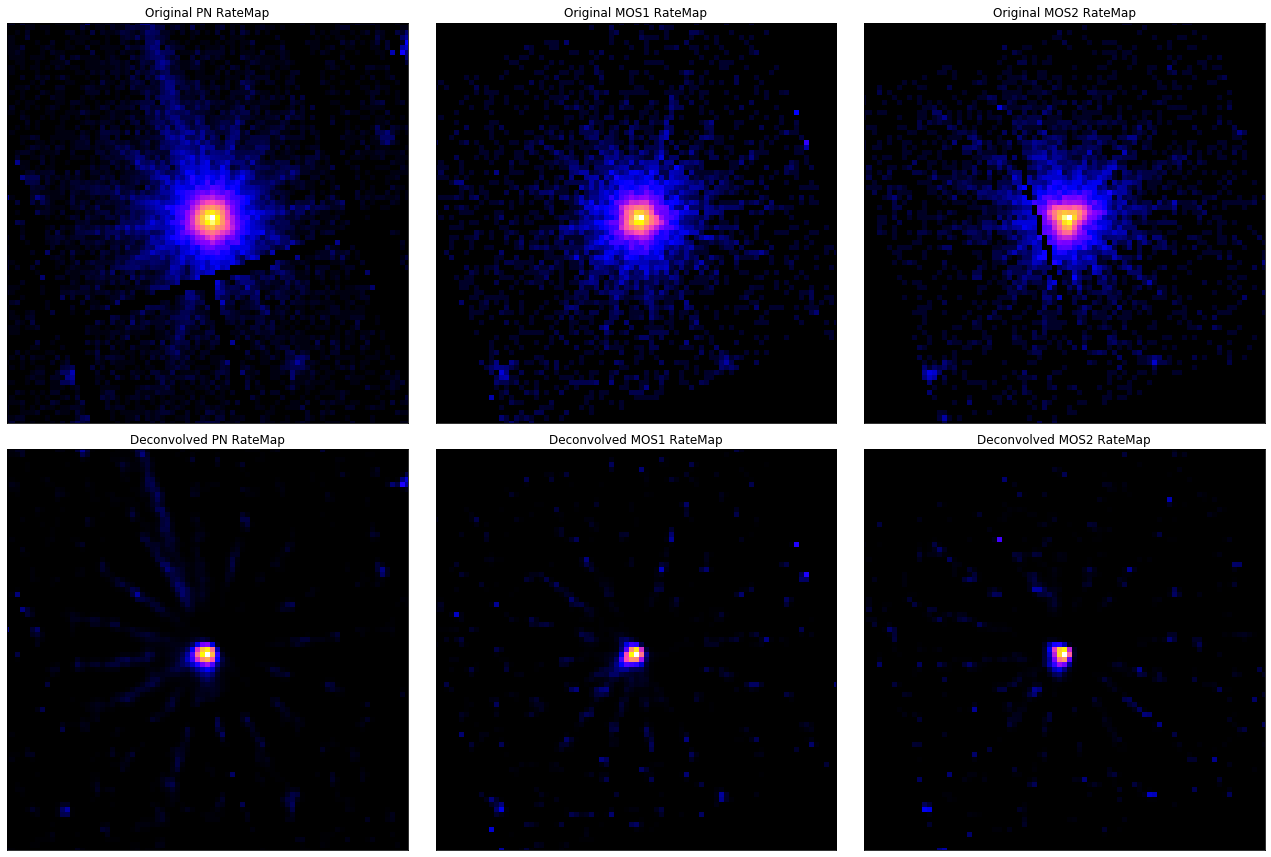

In [4]:
# This makes a nice comparison plot
fig, ax_arr = plt.subplots(ncols=3, nrows=2, figsize=(18, 12), sharey='row', sharex="col")
for ax_ind, ax in np.ndenumerate(ax_arr):
    ax.tick_params(axis='both', direction='in', which='both', top=False, right=False, left=False, bottom=False)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

# Plot the original and deconvolved PN ratemaps
norm = ImageNormalize(pointy_pn_rt.data, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[0, 0].imshow(pointy_pn_rt.data, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[0, 0].set_title("Original PN RateMap")
norm = ImageNormalize(pointy_pn_new_rt, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[1, 0].imshow(pointy_pn_new_rt, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[1, 0].set_title("Deconvolved PN RateMap")

# Plot the original and deconvolved MOS1 ratemaps
norm = ImageNormalize(pointy_mos1_rt.data, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[0, 1].imshow(pointy_mos1_rt.data, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[0, 1].set_title("Original MOS1 RateMap")
norm = ImageNormalize(pointy_mos1_new_rt, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[1, 1].imshow(pointy_mos1_new_rt, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[1, 1].set_title("Deconvolved MOS1 RateMap")

# Plot the original and deconvolved MOS2 images
norm = ImageNormalize(pointy_mos2_rt.data, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[0, 2].imshow(pointy_mos2_rt.data, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[0, 2].set_title("Original MOS2 RateMap")
norm = ImageNormalize(pointy_mos2_new_rt, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[1, 2].imshow(pointy_mos2_new_rt, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[1, 2].set_title("Deconvolved MOS2 RateMap")
# Shrinking the imshow axes size just so we can see them better

pix_gen_coord = pointy_mos1_rt.coord_conv(pointy_mos1_psf.ra_dec, pix)
box_size = 40
# Shrinking the imshow axes size just so we can see them better
for ax_ind, ax in np.ndenumerate(ax_arr):
    ax.set_xlim(pix_gen_coord.value[0]-box_size, pix_gen_coord.value[0]+box_size)
    ax.set_ylim(pix_gen_coord.value[1]-box_size, pix_gen_coord.value[1]+box_size)

fig.tight_layout()
plt.show()

### What difference does this make when combining ratemaps?

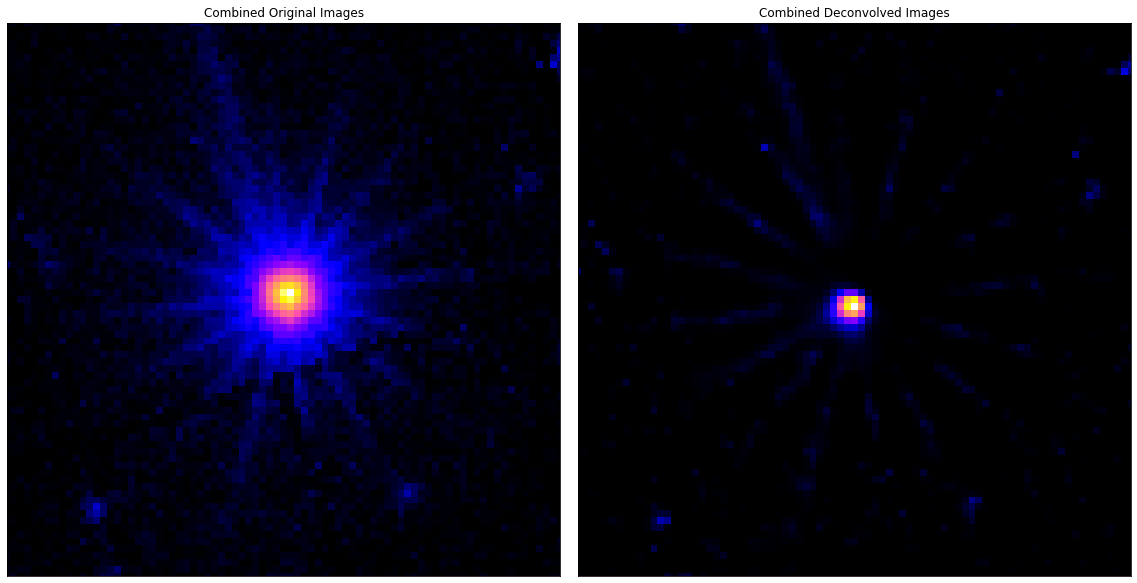

In [5]:
fig, ax_arr = plt.subplots(ncols=2, nrows=1, figsize=(16, 8), sharey='row',)
for ax in ax_arr:
    ax.tick_params(axis='both', direction='in', which='both', top=False, right=False, left=False, bottom=False)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    
# Adding the original image data together - doing it like this is fine for one ObsID with these images, because
#  they were made from sky coordinates.
pointy_comb_data = pointy_pn_rt.data + pointy_mos1_rt.data + pointy_mos2_rt.data
norm = ImageNormalize(pointy_comb_data, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[0].imshow(pointy_comb_data, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[0].set_title("Combined Original Images")

# Now adding the deconvolved image data together
pointy_comb_deconv_data = pointy_pn_new_rt + pointy_mos1_new_rt + pointy_mos2_new_rt
norm = ImageNormalize(pointy_comb_deconv_data, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[1].imshow(pointy_comb_deconv_data, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[1].set_title("Combined Deconvolved Images")

pix_gen_coord = pointy_mos1_rt.coord_conv(pointy_mos1_psf.ra_dec, pix)
box_size = 40
for ax_ind, ax in np.ndenumerate(ax_arr):
    ax.set_xlim(pix_gen_coord.value[0]-box_size, pix_gen_coord.value[0]+box_size)
    ax.set_ylim(pix_gen_coord.value[1]-box_size, pix_gen_coord.value[1]+box_size)

fig.tight_layout()
plt.show()

## Now I'll try with Castor a sextuple(!!) star system organised into three binary pairs

### Loading in images and PSFs, resampling PSFs to match images

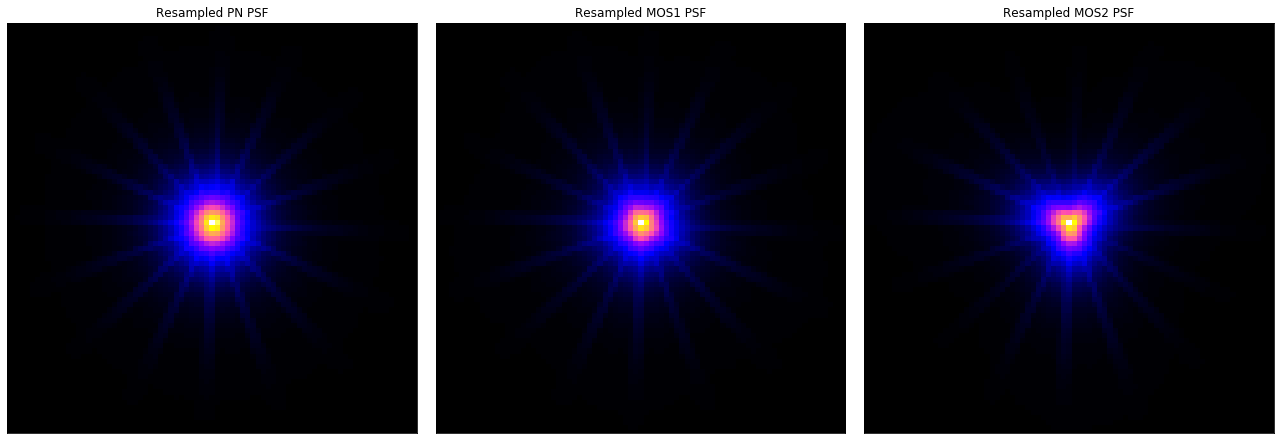

In [6]:
l = Quantity(0.5, "keV")
u = Quantity(2.0, "keV")

#--------------------------------Castor Star System---------------------------------------------#
# Will be useful for coordinate conversion
# Loading in PN image and PSF
castor_pn_im = Image("0112880801_pn_exp1-0.50-2.00keVimg.fits", "0112880801", "pn", "", "", "", l, u)
castor_pn_psf = PSF("pn_castor_psf_1250.fits", "ELLBETA", "0112880801", "pn", "", "", "")
# Should be working with ratemaps really, they have more physical meaning than straight images
castor_pn_ex = ExpMap("0112880801_pn_exp1-0.50-2.00keVexpmap.fits", "0112880801", "pn", "", "", "", l, u)
castor_pn_rt = RateMap(castor_pn_im, castor_pn_ex)
# Resamples the PSF array to match the image
castor_pn_new_psf = castor_pn_psf.resample(castor_pn_im, Quantity(256, 'pix'))

# Loading in MOS1 image and PSF
castor_mos1_im = Image("0112880801_mos1_exp1-0.50-2.00keVimg.fits", "0112880801", "mos1", "", "", "", l, u)
castor_mos1_psf = PSF("mos1_castor_psf_1250.fits", "ELLBETA", "0112880801", "mos1", "", "", "")
castor_mos1_ex = ExpMap("0112880801_mos1_exp1-0.50-2.00keVexpmap.fits", "0112880801", "mos1", "", "", "", l, u)
castor_mos1_rt = RateMap(castor_mos1_im, castor_mos1_ex)
castor_mos1_new_psf = castor_mos1_psf.resample(castor_mos1_im, Quantity(256, 'pix')) 

# Loading in MOS1 image and PSF
castor_mos2_im = Image("0112880801_mos2_exp1-0.50-2.00keVimg.fits", "0112880801", "mos2", "", "", "", l, u)
castor_mos2_psf = PSF("mos2_castor_psf_1250.fits", "ELLBETA", "0112880801", "mos2", "", "", "")
castor_mos2_ex = ExpMap("0112880801_mos2_exp1-0.50-2.00keVexpmap.fits", "0112880801", "mos2", "", "", "", l, u)
castor_mos2_rt = RateMap(castor_mos2_im, castor_mos2_ex)
castor_mos2_new_psf = castor_mos2_psf.resample(castor_mos2_im, Quantity(256, 'pix')) 
#----------------------------------------------------------------------------------------------#

fig, ax_arr = plt.subplots(ncols=3, nrows=1, figsize=(18, 6), sharey='row',)
for ax in ax_arr:
    ax.tick_params(axis='both', direction='in', which='both', top=False, right=False, left=False, bottom=False)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

# Plot the resampled PN PSF
norm = ImageNormalize(castor_pn_new_psf, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[0].imshow(castor_pn_new_psf, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[0].set_title("Resampled PN PSF")

# Plot the resampled MOS1 PSF
norm = ImageNormalize(castor_mos1_new_psf, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[1].imshow(castor_mos1_new_psf, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[1].set_title("Resampled MOS1 PSF")

# Plot the resampled MOS2 PSF
norm = ImageNormalize(castor_mos2_new_psf, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[2].imshow(castor_mos2_new_psf, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[2].set_title("Resampled MOS2 PSF")

for ax_ind, ax in np.ndenumerate(ax_arr):
    ax.set_xlim((castor_mos1_new_psf.shape[0]/2)-40, (castor_mos1_new_psf.shape[0]/2)+40)
    ax.set_ylim((castor_mos1_new_psf.shape[0]/2)-40, (castor_mos1_new_psf.shape[0]/2)+40)

fig.tight_layout()
plt.show()

### Deconvolving the PSFs with ratemaps

In [7]:
iterations = 15

# This is what runs the deconvolution
castor_pn_new_rt = restoration.richardson_lucy(castor_pn_rt.data, castor_pn_new_psf, clip=False, 
                                               iterations=iterations)
castor_mos1_new_rt = restoration.richardson_lucy(castor_mos1_rt.data, castor_mos1_new_psf, clip=False, 
                                                 iterations=iterations)
castor_mos2_new_rt = restoration.richardson_lucy(castor_mos2_rt.data, castor_mos2_new_psf, clip=False, 
                                                 iterations=iterations)

## And showing what has happened!

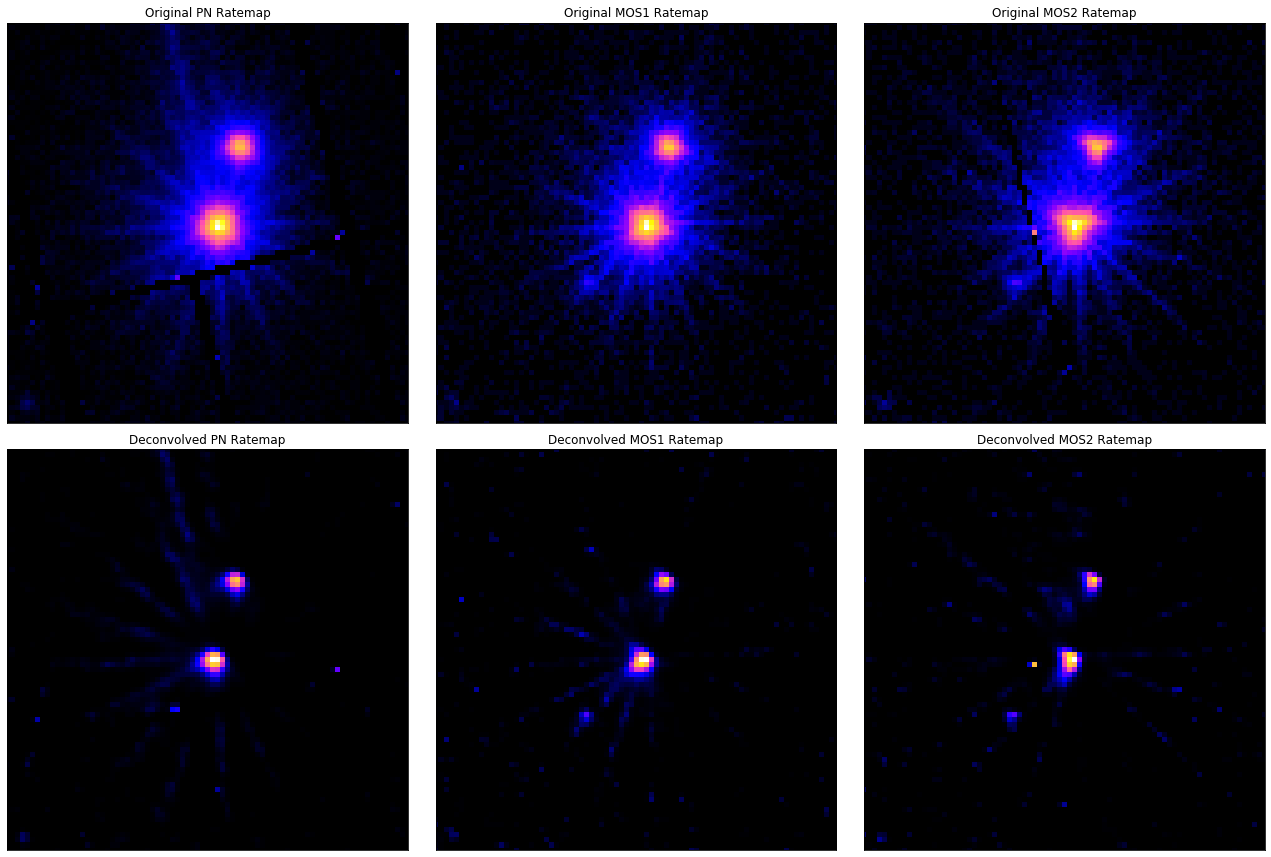

In [8]:
# This makes a nice comparison plot
fig, ax_arr = plt.subplots(ncols=3, nrows=2, figsize=(18, 12), sharey='row', sharex="col")
for ax_ind, ax in np.ndenumerate(ax_arr):
    ax.tick_params(axis='both', direction='in', which='both', top=False, right=False, left=False, bottom=False)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

# Plot the original and deconvolved PN ratemaps
norm = ImageNormalize(castor_pn_rt.data, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[0, 0].imshow(castor_pn_rt.data, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[0, 0].set_title("Original PN Ratemap")
norm = ImageNormalize(castor_pn_new_rt, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[1, 0].imshow(castor_pn_new_rt, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[1, 0].set_title("Deconvolved PN Ratemap")

# Plot the original and deconvolved MOS1 ratemaps
norm = ImageNormalize(castor_mos1_rt.data, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[0, 1].imshow(castor_mos1_rt.data, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[0, 1].set_title("Original MOS1 Ratemap")
norm = ImageNormalize(castor_mos1_new_rt, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[1, 1].imshow(castor_mos1_new_rt, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[1, 1].set_title("Deconvolved MOS1 Ratemap")

# Plot the original and deconvolved MOS2 ratemaps
norm = ImageNormalize(castor_mos2_rt.data, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[0, 2].imshow(castor_mos2_rt.data, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[0, 2].set_title("Original MOS2 Ratemap")
norm = ImageNormalize(castor_mos2_new_rt, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[1, 2].imshow(castor_mos2_new_rt, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[1, 2].set_title("Deconvolved MOS2 Ratemap")
# Shrinking the imshow axes size just so we can see them better

pix_gen_coord = castor_mos1_im.coord_conv(castor_mos1_psf.ra_dec, pix)
box_size = 40
# Shrinking the imshow axes size just so we can see them better
for ax_ind, ax in np.ndenumerate(ax_arr):
    ax.set_xlim(pix_gen_coord.value[0]-box_size, pix_gen_coord.value[0]+box_size)
    ax.set_ylim(pix_gen_coord.value[1]-box_size, pix_gen_coord.value[1]+box_size)

fig.tight_layout()
plt.show()

### What difference does this make when combining ratemaps?

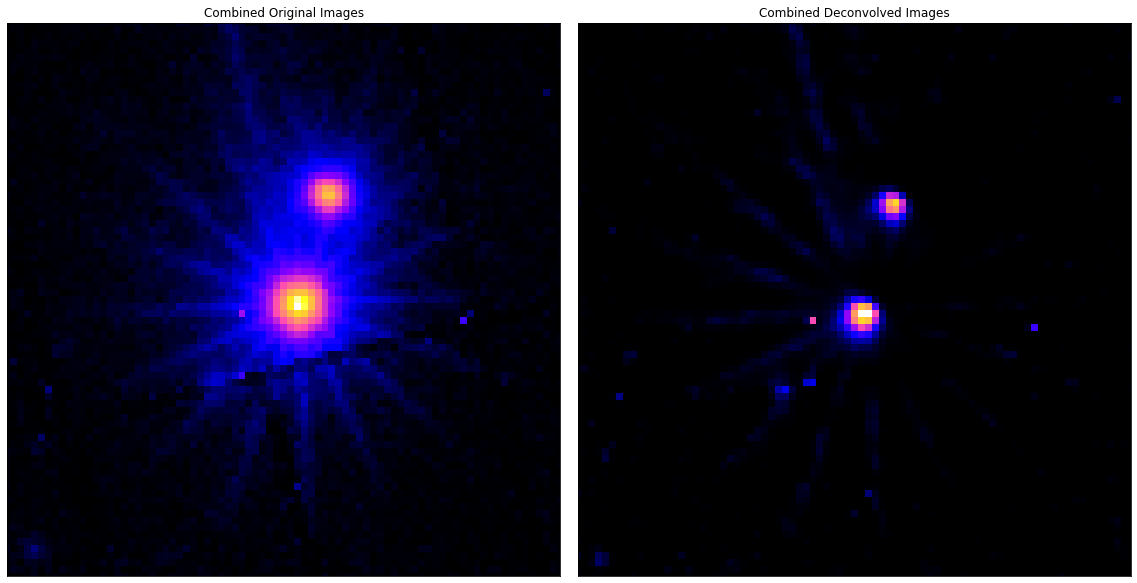

In [9]:
fig, ax_arr = plt.subplots(ncols=2, nrows=1, figsize=(16, 8), sharey='row',)
for ax in ax_arr:
    ax.tick_params(axis='both', direction='in', which='both', top=False, right=False, left=False, bottom=False)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    
# Adding the original ratemap data together - doing it like this is fine for one ObsID with these images, because
#  they were made from sky coordinates.
castor_comb_data = castor_pn_rt.data + castor_mos1_rt.data + castor_mos2_rt.data
norm = ImageNormalize(castor_comb_data, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[0].imshow(castor_comb_data, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[0].set_title("Combined Original Images")

# Now adding the deconvolved image data together
castor_comb_deconv_data = castor_pn_new_rt + castor_mos1_new_rt + castor_mos2_new_rt
norm = ImageNormalize(castor_comb_deconv_data, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[1].imshow(castor_comb_deconv_data, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[1].set_title("Combined Deconvolved Images")

pix_gen_coord = castor_mos1_im.coord_conv(castor_mos1_psf.ra_dec, pix)
box_size = 40
for ax_ind, ax in np.ndenumerate(ax_arr):
    ax.set_xlim(pix_gen_coord.value[0]-box_size, pix_gen_coord.value[0]+box_size)
    ax.set_ylim(pix_gen_coord.value[1]-box_size, pix_gen_coord.value[1]+box_size)

fig.tight_layout()
plt.show()

## One ObsID of my favourite cluster - Abell 907

### Loading in images and PSFs, resampling PSFs to match images

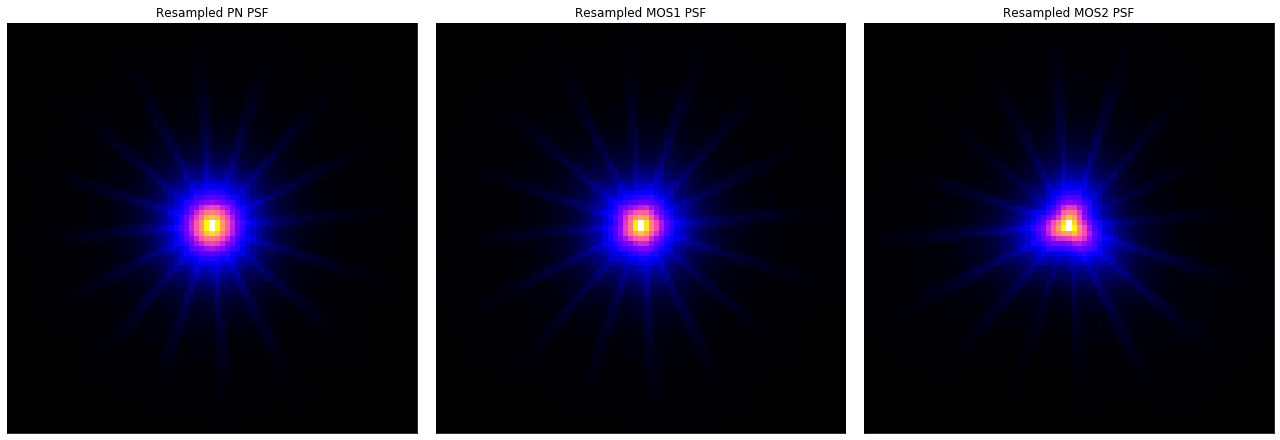

In [10]:
l = Quantity(0.5, "keV")
u = Quantity(2.0, "keV")

psf_size = 512

#--------------------------------Abell 907 Cluster----------------------------------------------#
# Will be useful for coordinate conversion
# Loading in PN image and PSF
a907_pn_im = Image("0201903501_pn_exp1-0.50-2.00keVimg.fits", "0201903501", "pn", "", "", "", l, u)
a907_pn_psf = PSF("pn_a907_psf_1250.fits", "ELLBETA", "0201903501", "pn", "", "", "")
a907_pn_ex = ExpMap("0201903501_pn_exp1-0.50-2.00keVexpmap.fits", "0201903501", "pn", "", "", "", l, u)
a907_pn_rt = RateMap(a907_pn_im, a907_pn_ex)
# Resamples the PSF array to match the image
a907_pn_new_psf = a907_pn_psf.resample(a907_pn_im, Quantity(psf_size, 'pix'))

# Loading in MOS1 image and PSF
a907_mos1_im = Image("0201903501_mos1_exp1-0.50-2.00keVimg.fits", "0201903501", "mos1", "", "", "", l, u)
a907_mos1_psf = PSF("mos1_a907_psf_1250.fits", "ELLBETA", "0201903501", "mos1", "", "", "")
a907_mos1_ex = ExpMap("0201903501_mos1_exp1-0.50-2.00keVexpmap.fits", "0201903501", "mos1", "", "", "", l, u)
a907_mos1_rt = RateMap(a907_mos1_im, a907_mos1_ex)
a907_mos1_new_psf = a907_mos1_psf.resample(a907_mos1_im, Quantity(psf_size, 'pix'))

# Loading in MOS2 image and PSF
a907_mos2_im = Image("0201903501_mos2_exp1-0.50-2.00keVimg.fits", "0201903501", "mos2", "", "", "", l, u)
a907_mos2_psf = PSF("mos2_a907_psf_1250.fits", "ELLBETA", "0201903501", "mos2", "", "", "")
a907_mos2_ex = ExpMap("0201903501_mos2_exp1-0.50-2.00keVexpmap.fits", "0201903501", "mos2", "", "", "", l, u)
a907_mos2_rt = RateMap(a907_mos2_im, a907_mos2_ex)
a907_mos2_new_psf = a907_mos2_psf.resample(a907_mos2_im, Quantity(psf_size, 'pix'))
#----------------------------------------------------------------------------------------------#

fig, ax_arr = plt.subplots(ncols=3, nrows=1, figsize=(18, 6), sharey='row',)
for ax in ax_arr:
    ax.tick_params(axis='both', direction='in', which='both', top=False, right=False, left=False, bottom=False)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

# Plot the resampled PN PSF
norm = ImageNormalize(a907_pn_new_psf, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[0].imshow(a907_pn_new_psf, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[0].set_title("Resampled PN PSF")

# Plot the resampled MOS1 PSF
norm = ImageNormalize(a907_mos1_new_psf, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[1].imshow(a907_mos1_new_psf, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[1].set_title("Resampled MOS1 PSF")

# Plot the resampled MOS2 PSF
norm = ImageNormalize(a907_mos2_new_psf, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[2].imshow(a907_mos2_new_psf, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[2].set_title("Resampled MOS2 PSF")

for ax_ind, ax in np.ndenumerate(ax_arr):
    ax.set_xlim((a907_mos1_new_psf.shape[0]/2)-40, (a907_mos1_new_psf.shape[0]/2)+40)
    ax.set_ylim((a907_mos1_new_psf.shape[0]/2)-40, (a907_mos1_new_psf.shape[0]/2)+40)

fig.tight_layout()
plt.show()

### Deconvolving the PSFs with ratemaps

In [11]:
def lr(image, psf, iterations=50, clip=True):
    image = image.astype(np.float)
    psf = psf.astype(np.float)
    im_deconv = np.full(image.shape, 0.5)
    psf_mirror = psf[::-1, ::-1]

    for _ in range(iterations):
        relative_blur = image / convolve(im_deconv, psf, mode='same', method='fft')
        im_deconv *= convolve(relative_blur, psf_mirror, mode='same', method='fft')

    if clip:
        im_deconv[im_deconv > 1] = 1
        im_deconv[im_deconv < -1] = -1

    return im_deconv

In [12]:
iterations = 15
pn_boi = a907_pn_rt.data + a907_pn_rt.data.max() * 1E-5 * np.random.random(a907_pn_rt.shape)
pn_boi += a907_pn_rt.data.max().max() * 1E-5

mos1_boi = a907_mos1_rt.data + a907_mos1_rt.data.max() * 1E-5 * np.random.random(a907_mos1_rt.shape)
mos1_boi += a907_mos1_rt.data.max().max() * 1E-5

mos2_boi = a907_mos2_rt.data + a907_mos2_rt.data.max() * 1E-5 * np.random.random(a907_mos2_rt.shape)
mos2_boi += a907_mos2_rt.data.max().max() * 1E-5


# This is what runs the deconvolution
# a907_pn_new_rt = restoration.richardson_lucy(pn_boi, a907_pn_new_psf, clip=False, iterations=iterations)
a907_pn_new_rt = lr(pn_boi, a907_pn_new_psf, clip=False, iterations=iterations)

a907_pn_new_rt *= a907_pn_rt.data.sum() / a907_pn_new_rt.sum()

# a907_mos1_new_rt = restoration.richardson_lucy(mos1_boi, a907_mos1_new_psf, clip=False, iterations=iterations)
a907_mos1_new_rt = lr(mos1_boi, a907_mos1_new_psf, clip=False, iterations=iterations)

a907_mos1_new_rt *= a907_mos1_rt.data.sum() / a907_mos1_new_rt.sum()

# a907_mos2_new_rt = restoration.richardson_lucy(mos2_boi, a907_mos2_new_psf, clip=False, iterations=iterations)
a907_mos2_new_rt = lr(mos2_boi, a907_mos2_new_psf, clip=False, iterations=iterations)

a907_mos2_new_rt *= a907_mos2_rt.data.sum() / a907_mos2_new_rt.sum()

# Trying a different PSF deconvolution algorithm
# a907_pn_new_rt = restoration.unsupervised_wiener(a907_pn_rt.data, a907_pn_new_psf, clip=False)
# a907_mos1_new_rt = restoration.unsupervised_wiener(a907_mos1_rt.data, a907_mos1_new_psf, clip=False)
# a907_mos2_new_rt = restoration.unsupervised_wiener(a907_mos2_rt.data, a907_mos2_new_psf, clip=False)

## And showing what has happened!

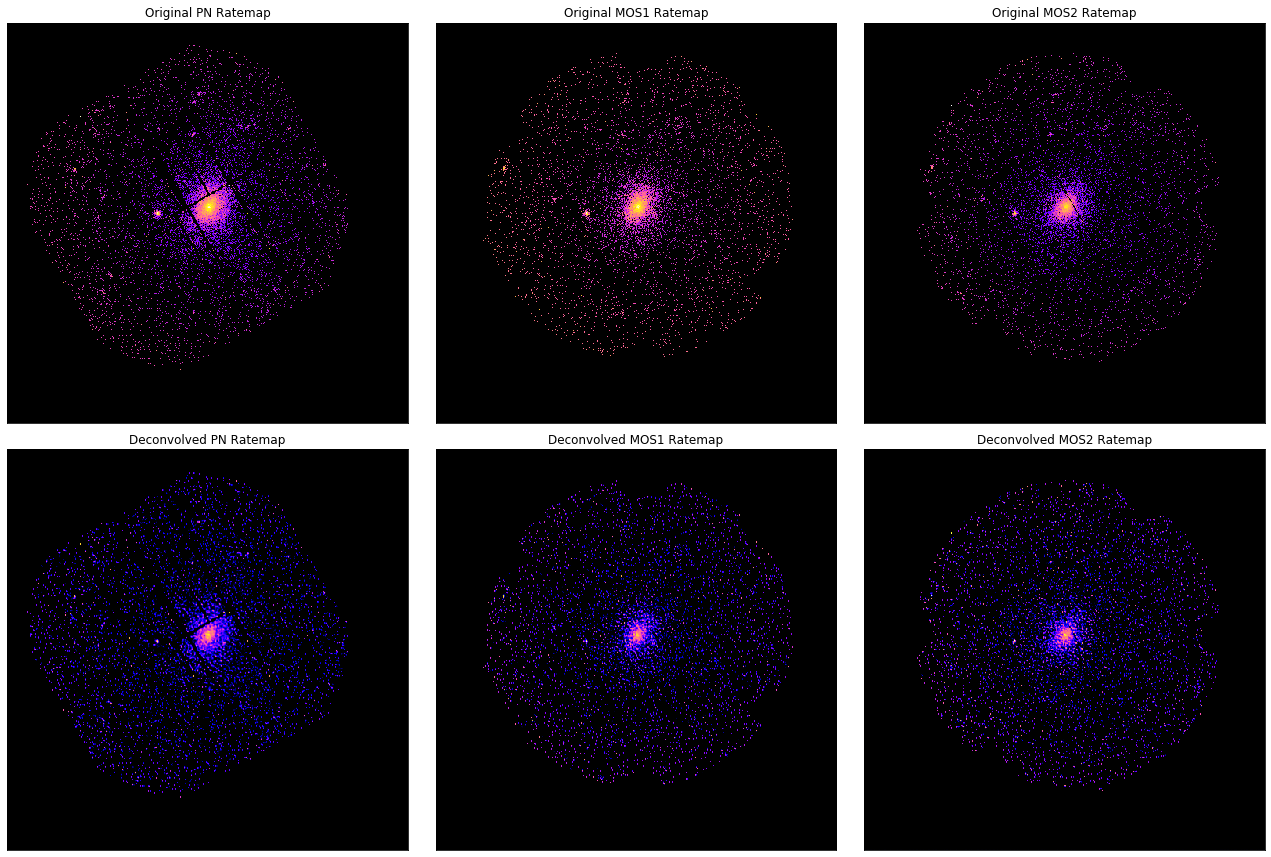

In [13]:
# This makes a nice comparison plot
fig, ax_arr = plt.subplots(ncols=3, nrows=2, figsize=(18, 12), sharey='row', sharex="col")
for ax_ind, ax in np.ndenumerate(ax_arr):
    ax.tick_params(axis='both', direction='in', which='both', top=False, right=False, left=False, bottom=False)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

# Plot the original and deconvolved PN ratemaps
norm = ImageNormalize(a907_pn_rt.data, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[0, 0].imshow(a907_pn_rt.data, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[0, 0].set_title("Original PN Ratemap")
norm = ImageNormalize(a907_pn_new_rt, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[1, 0].imshow(a907_pn_new_rt, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[1, 0].set_title("Deconvolved PN Ratemap")

# Plot the original and deconvolved MOS1 ratemaps
norm = ImageNormalize(a907_mos1_rt.data, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[0, 1].imshow(a907_mos1_rt.data, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[0, 1].set_title("Original MOS1 Ratemap")
norm = ImageNormalize(a907_mos1_new_rt, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[1, 1].imshow(a907_mos1_new_rt, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[1, 1].set_title("Deconvolved MOS1 Ratemap")

# Plot the original and deconvolved MOS2 ratemaps
norm = ImageNormalize(a907_mos2_rt.data, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[0, 2].imshow(a907_mos2_rt.data, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[0, 2].set_title("Original MOS2 Ratemap")
norm = ImageNormalize(a907_mos2_new_rt, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[1, 2].imshow(a907_mos2_new_rt, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[1, 2].set_title("Deconvolved MOS2 Ratemap")
# Shrinking the imshow axes size just so we can see them better

pix_gen_coord = a907_mos1_im.coord_conv(a907_mos1_psf.ra_dec, pix)
box_size = 80
# Shrinking the imshow axes size just so we can see them better
# for ax_ind, ax in np.ndenumerate(ax_arr):
#     ax.set_xlim(pix_gen_coord.value[0]-box_size, pix_gen_coord.value[0]+box_size)
#     ax.set_ylim(pix_gen_coord.value[1]-box_size, pix_gen_coord.value[1]+box_size)

fig.tight_layout()
plt.show()

### What difference does this make when combining ratemaps?

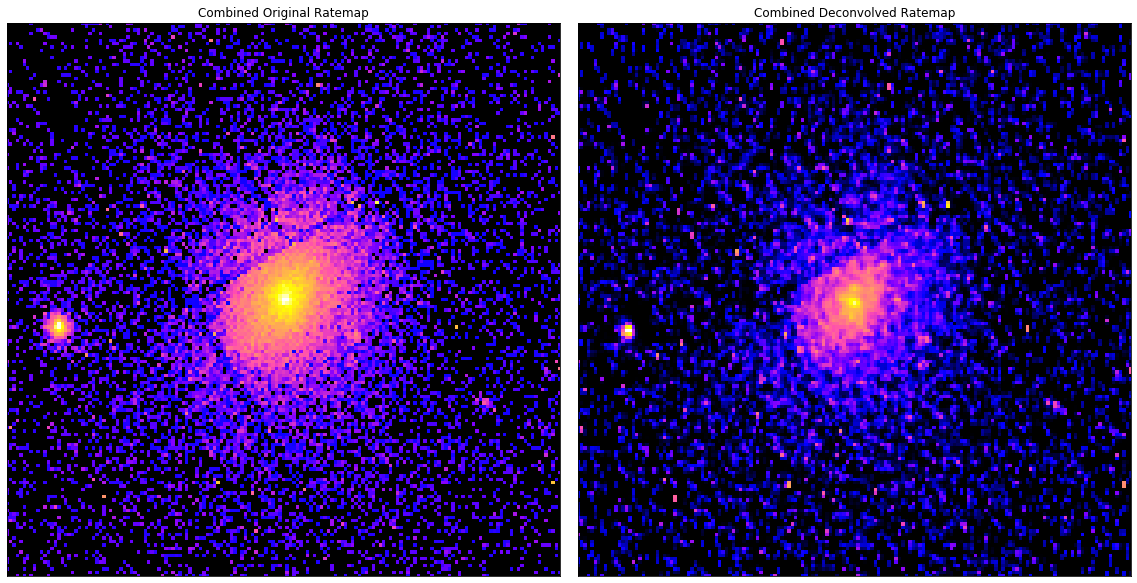

In [14]:
fig, ax_arr = plt.subplots(ncols=2, nrows=1, figsize=(16, 8), sharey='row',)
for ax in ax_arr:
    ax.tick_params(axis='both', direction='in', which='both', top=False, right=False, left=False, bottom=False)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    
# Adding the original ratemap data together - doing it like this is fine for one ObsID with these images, because
#  they were made from sky coordinates.
a907_comb_data = a907_pn_rt.data + a907_mos1_rt.data + a907_mos2_rt.data
norm = ImageNormalize(a907_comb_data, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[0].imshow(a907_comb_data, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[0].set_title("Combined Original Ratemap")

# Now adding the deconvolved ratemap data together
a907_comb_deconv_data = a907_pn_new_rt + a907_mos1_new_rt + a907_mos2_new_rt
norm = ImageNormalize(a907_comb_deconv_data, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[1].imshow(a907_comb_deconv_data, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[1].set_title("Combined Deconvolved Ratemap")

pix_gen_coord = a907_mos1_im.coord_conv(a907_mos1_psf.ra_dec, pix)
box_size = 80
for ax_ind, ax in np.ndenumerate(ax_arr):
    ax.set_xlim(pix_gen_coord.value[0]-box_size, pix_gen_coord.value[0]+box_size)
    ax.set_ylim(pix_gen_coord.value[1]-box_size, pix_gen_coord.value[1]+box_size)

fig.tight_layout()
plt.show()

## Bodging these combined ratemaps into ratemap objects

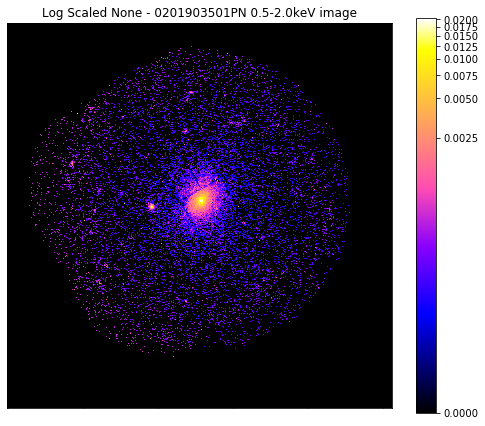

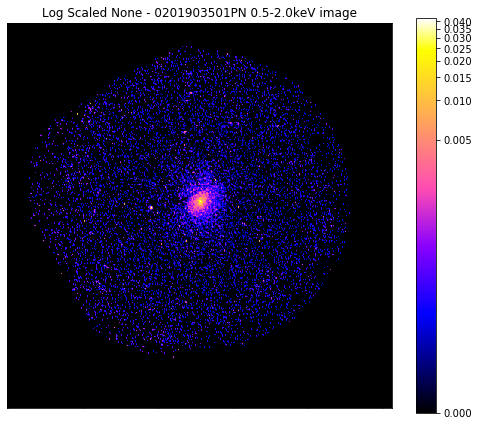

In [15]:
# Have to bodge the image and exposure map objects because these combined images have not been written to a file
a907_comb_rt = deepcopy(a907_pn_im)
# Manually add the new combined data - this is bad because the instrument and other stuff is wrong, but it'll do
a907_comb_rt.data = a907_comb_data

# And also bodge the deconvolved data into a RateMap
a907_comb_deconv_rt = deepcopy(a907_pn_im)
a907_comb_deconv_rt.data = a907_comb_deconv_data

# Also check that the process has worked
a907_comb_rt.view()
a907_comb_deconv_rt.view()

## Radial brightness profiles - what has changed?

### How big is one pixel in kpc? - for scaling the surface brightness

In [16]:
# How big is one pixel in kpc
pix_loc = a907_mos1_im.coord_conv(a907_mos1_psf.ra_dec, pix)
new_deg_loc = a907_mos1_im.coord_conv(pix_loc+Quantity([1, 0], pix), deg)
pix_kpc = ang_to_rad(abs(new_deg_loc - a907_mos1_psf.ra_dec)[0], 0.16)

### Actually plotting the profile

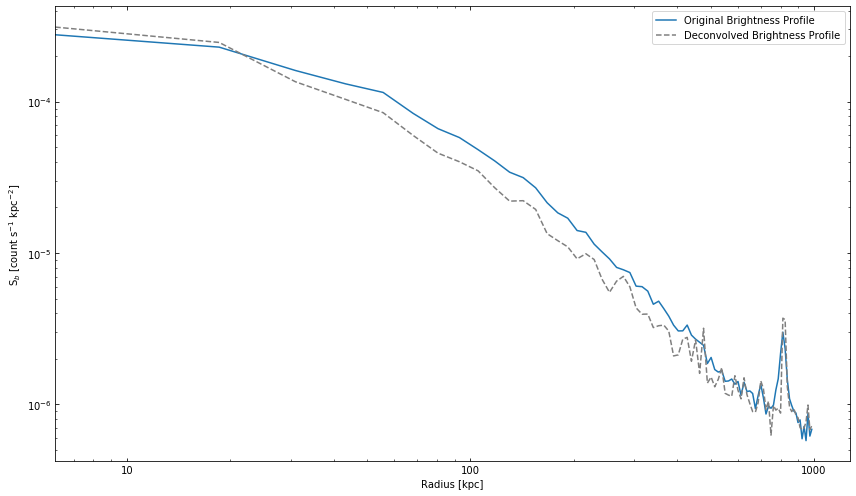

In [17]:
# Too much hassle to get a proper mask at this point, so just making a flat mask
# Means the background measurement is bollocks
flat_mask = np.ones(a907_comb_rt.shape)

# Setup the figure
plt.figure(figsize=(12, 7))
ax = plt.gca()

# Centering at the original peak used to generate the PSFs
pix_loc = a907_mos1_im.coord_conv(a907_mos1_psf.ra_dec, pix)
# Getting the radial profile for the normal stacked ratemaps
brightness, br_err, radii, background, inn_r, out_r = radial_brightness(a907_comb_rt, flat_mask, flat_mask, pix_loc,
                                                  Quantity(1000, 'kpc'), 0.16, 1, kpc)
brightness /= pix_kpc.value**2
plt.plot(radii, brightness, label="Original Brightness Profile", color="tab:blue")

# Getting the radial profile for the deconvolved stacked ratemaps
brightness, br_err, radii, background, inn_r, out_r = radial_brightness(a907_comb_deconv_rt, flat_mask, flat_mask, pix_loc,
                                                  Quantity(1000, 'kpc'), 0.16, 1, kpc)
brightness /= pix_kpc.value**2

plt.plot(radii, brightness, label="Deconvolved Brightness Profile", color="tab:gray", linestyle="--")

# This adds small ticks to the axis
ax.minorticks_on()
# Adjusts how the ticks look
ax.tick_params(axis='both', direction='in', which='both', top=True, right=True)
# This would add a grid but I think it might look better without
# ax.grid(linestyle='dotted', linewidth=1)
# Choose y-axis log scaling because otherwise you can't really make out the profiles very well
ax.set_yscale("log")
ax.set_xscale('log')
ax.xaxis.set_major_formatter(ScalarFormatter())

# Set the lower limit of the x-axis to 0
ax.set_xlim(radii.min().value,)
# Labels and legends
ax.set_ylabel("S$_{b}$ [count s$^{-1}$ kpc$^{-2}$]")
ax.set_xlabel("Radius [kpc]")
plt.legend(loc="best")
# Removes white space around the plot
plt.tight_layout()
# Plots the plot
plt.show()

## Now gonna see what happens to an off axis cluster

### Loading in images and PSFs, resampling PSFs to match images

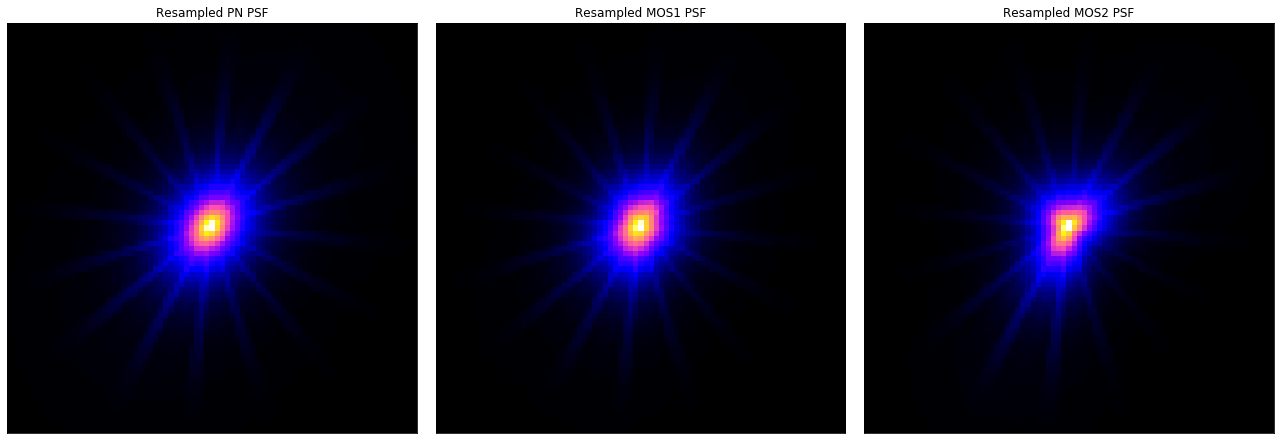

In [18]:
l = Quantity(0.5, "keV")
u = Quantity(2.0, "keV")

psf_size = 64

#--------------------------------Abell 907 Cluster----------------------------------------------#
# Will be useful for coordinate conversion
# Loading in PN image and PSF
off_pn_im = Image("0675010901_pn_exp1-0.50-2.00keVimg.fits", "0675010901", "pn", "", "", "", l, u)
off_pn_psf = PSF("pn_offax_psf_1250.fits", "ELLBETA", "0675010901", "pn", "", "", "")
off_pn_ex = ExpMap("0675010901_pn_exp1-0.50-2.00keVexpmap.fits", "0675010901", "pn", "", "", "", l, u)
off_pn_rt = RateMap(off_pn_im, off_pn_ex)
# Resamples the PSF array to match the image
off_pn_new_psf = off_pn_psf.resample(off_pn_im, Quantity(psf_size, 'pix'))

# Loading in MOS1 image and PSF
off_mos1_im = Image("0675010901_mos1_exp1-0.50-2.00keVimg.fits", "0675010901", "mos1", "", "", "", l, u)
off_mos1_psf = PSF("mos1_offax_psf_1250.fits", "ELLBETA", "0675010901", "mos1", "", "", "")
off_mos1_ex = ExpMap("0675010901_mos1_exp1-0.50-2.00keVexpmap.fits", "0675010901", "mos1", "", "", "", l, u)
off_mos1_rt = RateMap(off_mos1_im, off_mos1_ex)
off_mos1_new_psf = off_mos1_psf.resample(off_mos1_im, Quantity(psf_size, 'pix'))

# Loading in MOS2 image and PSF
off_mos2_im = Image("0675010901_mos2_exp1-0.50-2.00keVimg.fits", "0675010901", "mos2", "", "", "", l, u)
off_mos2_psf = PSF("mos2_offax_psf_1250.fits", "ELLBETA", "0675010901", "mos2", "", "", "")
off_mos2_ex = ExpMap("0675010901_mos2_exp1-0.50-2.00keVexpmap.fits", "0675010901", "mos2", "", "", "", l, u)
off_mos2_rt = RateMap(off_mos2_im, off_mos2_ex)
off_mos2_new_psf = off_mos2_psf.resample(off_mos2_im, Quantity(psf_size, 'pix'))
#----------------------------------------------------------------------------------------------#

fig, ax_arr = plt.subplots(ncols=3, nrows=1, figsize=(18, 6), sharey='row',)
for ax in ax_arr:
    ax.tick_params(axis='both', direction='in', which='both', top=False, right=False, left=False, bottom=False)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

# Plot the resampled PN PSF
norm = ImageNormalize(off_pn_new_psf, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[0].imshow(off_pn_new_psf, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[0].set_title("Resampled PN PSF")

# Plot the resampled MOS1 PSF
norm = ImageNormalize(off_mos1_new_psf, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[1].imshow(off_mos1_new_psf, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[1].set_title("Resampled MOS1 PSF")

# Plot the resampled MOS2 PSF
norm = ImageNormalize(off_mos2_new_psf, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[2].imshow(off_mos2_new_psf, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[2].set_title("Resampled MOS2 PSF")

for ax_ind, ax in np.ndenumerate(ax_arr):
    ax.set_xlim((off_mos1_new_psf.shape[0]/2)-40, (off_mos1_new_psf.shape[0]/2)+40)
    ax.set_ylim((off_mos1_new_psf.shape[0]/2)-40, (off_mos1_new_psf.shape[0]/2)+40)

fig.tight_layout()
plt.show()

### Deconvolving the PSFs with ratemaps

In [19]:
iterations = 15
pn_boi = off_pn_rt.data + off_pn_rt.data.max() * 1E-5 * np.random.random(off_pn_rt.shape)
pn_boi += off_pn_rt.data.max().max() * 1E-5

mos1_boi = off_mos1_rt.data + off_mos1_rt.data.max() * 1E-5 * np.random.random(off_mos1_rt.shape)
mos1_boi += off_mos1_rt.data.max().max() * 1E-5

mos2_boi = off_mos2_rt.data + off_mos2_rt.data.max() * 1E-5 * np.random.random(off_mos2_rt.shape)
mos2_boi += off_mos2_rt.data.max().max() * 1E-5


# This is what runs the deconvolution
off_pn_new_rt = restoration.richardson_lucy(pn_boi*off_pn_rt._edge_mask, off_pn_new_psf, clip=False, iterations=iterations)
# off_pn_new_rt = lr(pn_boi, off_pn_new_psf, clip=False, iterations=iterations)

off_pn_new_rt *= off_pn_rt.data.sum() / off_pn_new_rt.sum()

off_mos1_new_rt = restoration.richardson_lucy(mos1_boi*off_mos1_rt._edge_mask, off_mos1_new_psf, clip=False, iterations=iterations)
# off_mos1_new_rt = lr(mos1_boi, off_mos1_new_psf, clip=False, iterations=iterations)

off_mos1_new_rt *= off_mos1_rt.data.sum() / off_mos1_new_rt.sum()

off_mos2_new_rt = restoration.richardson_lucy(mos2_boi*off_mos2_rt._edge_mask, off_mos2_new_psf, clip=False, iterations=iterations)
# off_mos2_new_rt = lr(mos2_boi, off_mos2_new_psf, clip=False, iterations=iterations)

off_mos2_new_rt *= off_mos2_rt.data.sum() / off_mos2_new_rt.sum()

## And showing what has happened!

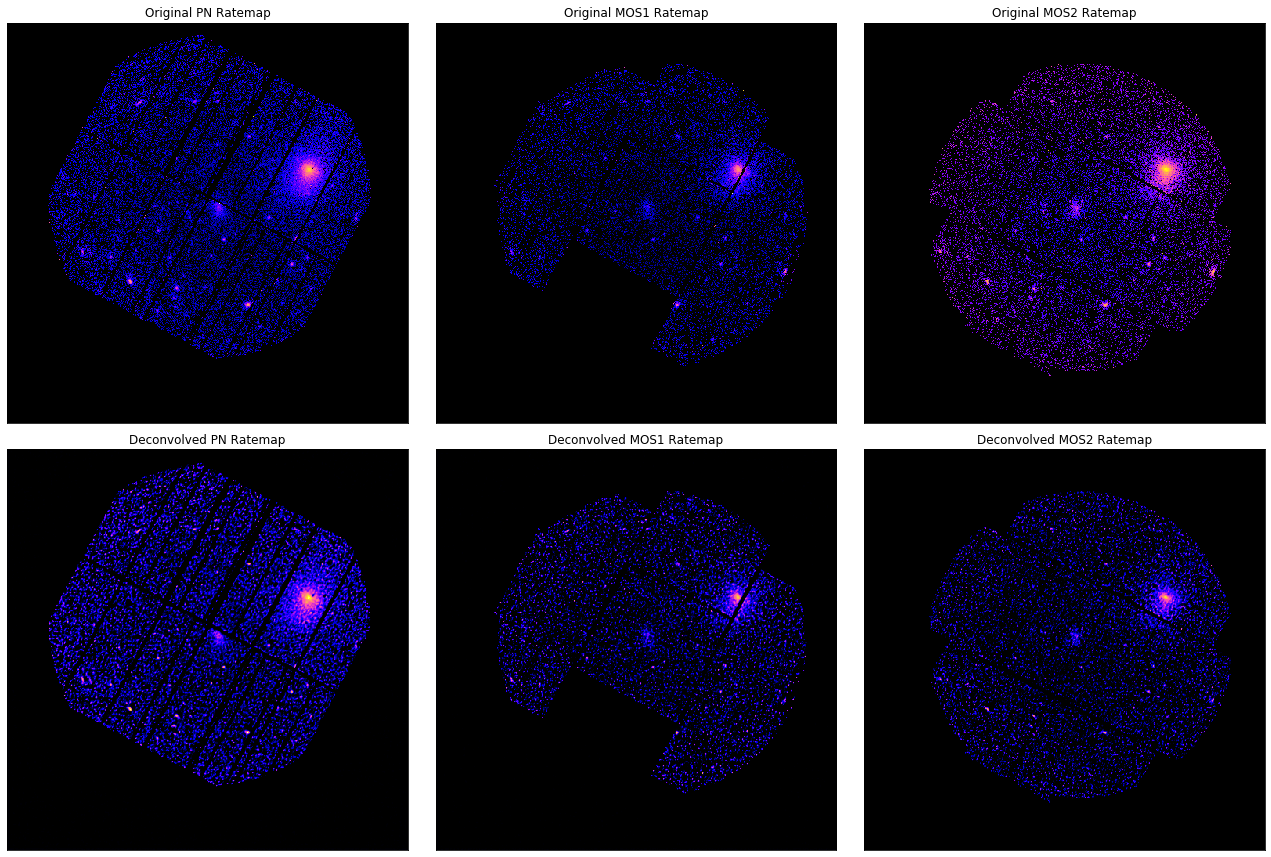

In [20]:
# This makes a nice comparison plot
fig, ax_arr = plt.subplots(ncols=3, nrows=2, figsize=(18, 12), sharey='row', sharex="col")
for ax_ind, ax in np.ndenumerate(ax_arr):
    ax.tick_params(axis='both', direction='in', which='both', top=False, right=False, left=False, bottom=False)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

# Plot the original and deconvolved PN ratemaps
norm = ImageNormalize(off_pn_rt.data, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[0, 0].imshow(off_pn_rt.data, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[0, 0].set_title("Original PN Ratemap")
norm = ImageNormalize(off_pn_new_rt, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[1, 0].imshow(off_pn_new_rt, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[1, 0].set_title("Deconvolved PN Ratemap")

# Plot the original and deconvolved MOS1 ratemaps
norm = ImageNormalize(off_mos1_rt.data, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[0, 1].imshow(off_mos1_rt.data, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[0, 1].set_title("Original MOS1 Ratemap")
norm = ImageNormalize(off_mos1_new_rt, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[1, 1].imshow(off_mos1_new_rt, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[1, 1].set_title("Deconvolved MOS1 Ratemap")

# Plot the original and deconvolved MOS2 ratemaps
norm = ImageNormalize(off_mos2_rt.data, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[0, 2].imshow(off_mos2_rt.data, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[0, 2].set_title("Original MOS2 Ratemap")
norm = ImageNormalize(off_mos2_new_rt, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[1, 2].imshow(off_mos2_new_rt, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[1, 2].set_title("Deconvolved MOS2 Ratemap")
# Shrinking the imshow axes size just so we can see them better

pix_gen_coord = off_mos1_im.coord_conv(off_mos1_psf.ra_dec, pix)
box_size = 80
# Shrinking the imshow axes size just so we can see them better
# for ax_ind, ax in np.ndenumerate(ax_arr):
#     ax.set_xlim(pix_gen_coord.value[0]-box_size, pix_gen_coord.value[0]+box_size)
#     ax.set_ylim(pix_gen_coord.value[1]-box_size, pix_gen_coord.value[1]+box_size)

fig.tight_layout()
plt.show()

### What difference does this make when combining ratemaps?

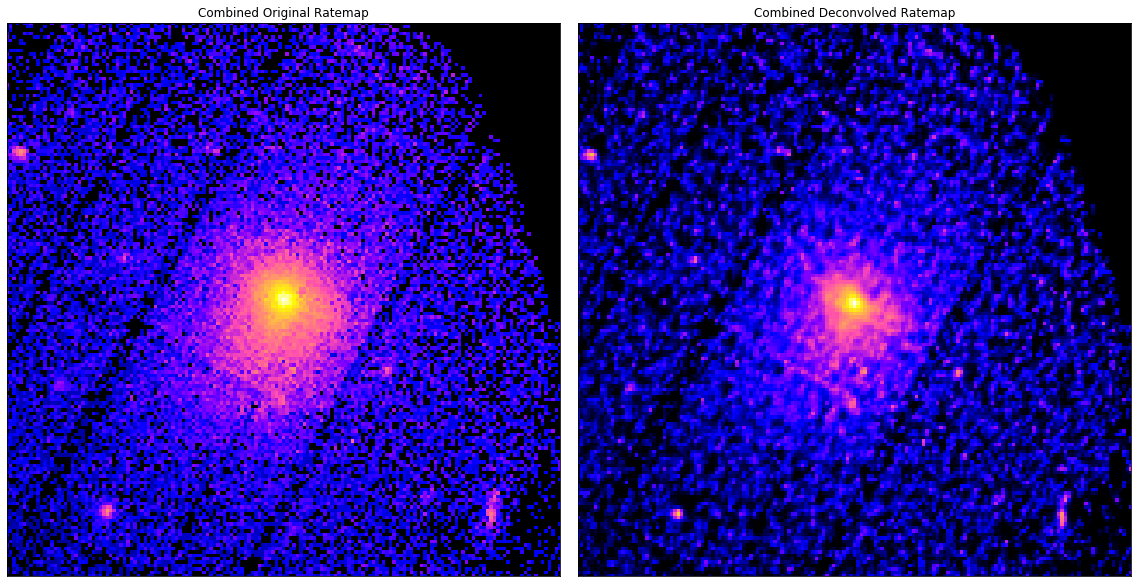

In [21]:
fig, ax_arr = plt.subplots(ncols=2, nrows=1, figsize=(16, 8), sharey='row',)
for ax in ax_arr:
    ax.tick_params(axis='both', direction='in', which='both', top=False, right=False, left=False, bottom=False)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    
# Adding the original ratemap data together - doing it like this is fine for one ObsID with these images, because
#  they were made from sky coordinates.
off_comb_data = off_pn_rt.data*off_pn_rt._edge_mask + off_mos1_rt.data*off_mos1_rt._edge_mask + off_mos2_rt.data*off_mos2_rt._edge_mask
norm = ImageNormalize(off_comb_data, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[0].imshow(off_comb_data, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[0].set_title("Combined Original Ratemap")

# Now adding the deconvolved ratemap data together
off_comb_deconv_data = off_pn_new_rt + off_mos1_new_rt + off_mos2_new_rt
norm = ImageNormalize(off_comb_deconv_data, interval=MinMaxInterval(), stretch=LogStretch())
ax_arr[1].imshow(off_comb_deconv_data, origin="lower", norm=norm, cmap="gnuplot2")
ax_arr[1].set_title("Combined Deconvolved Ratemap")

pix_gen_coord = off_mos1_im.coord_conv(off_mos1_psf.ra_dec, pix)
box_size = 80
for ax_ind, ax in np.ndenumerate(ax_arr):
    ax.set_xlim(pix_gen_coord.value[0]-box_size, pix_gen_coord.value[0]+box_size)
    ax.set_ylim(pix_gen_coord.value[1]-box_size, pix_gen_coord.value[1]+box_size)

fig.tight_layout()
plt.show()

## Bodging these combined ratemaps into ratemap objects

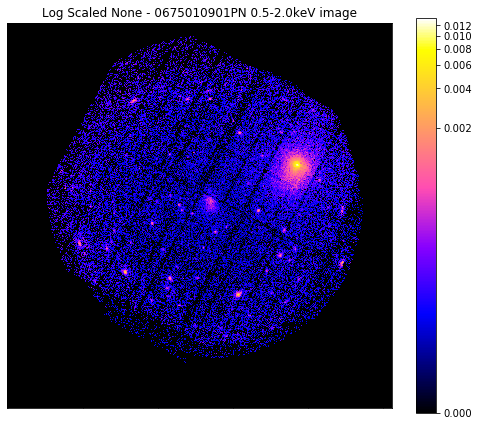

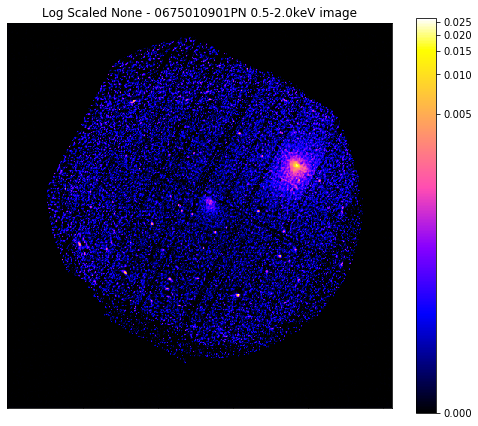

In [22]:
# Have to bodge the image and exposure map objects because these combined images have not been written to a file
off_comb_rt = deepcopy(off_pn_im)
# Manually add the new combined data - this is bad because the instrument and other stuff is wrong, but it'll do
off_comb_rt.data = off_comb_data

# And also bodge the deconvolved data into a RateMap
off_comb_deconv_rt = deepcopy(off_pn_im)
off_comb_deconv_rt.data = off_comb_deconv_data

# Also check that the process has worked
off_comb_rt.view()
off_comb_deconv_rt.view()

## Radial brightness profiles - what has changed?

### How big is one pixel in kpc? - for scaling the surface brightness

In [23]:
# How big is one pixel in kpc
pix_loc = off_mos1_im.coord_conv(off_mos1_psf.ra_dec, pix)
new_deg_loc = off_mos1_im.coord_conv(pix_loc+Quantity([1, 0], pix), deg)
pix_kpc = ang_to_rad(abs(new_deg_loc - off_mos1_psf.ra_dec)[0], 0.16)

### Actually plotting the profile

[  5.37333724  16.12001171  26.86668618  37.61336065  48.36003512
  59.10670959  69.85338406  80.60005853  91.346733   102.09340748
 112.84008195 123.58675642 134.33343089 145.08010536 155.82677983
 166.5734543  177.32012877 188.06680324 198.81347772 209.56015219
 220.30682666 231.05350113 241.8001756  252.54685007 263.29352454
 274.04019901 284.78687348 295.53354796 306.28022243 317.0268969
 327.77357137 338.52024584 349.26692031 360.01359478 370.76026925
 381.50694373 392.2536182  403.00029267 413.74696714 424.49364161
 435.24031608 445.98699055 456.73366502 467.48033949 478.22701397
 488.97368844 499.72036291 510.46703738 521.21371185 531.96038632
 542.70706079 553.45373526 564.20040973 574.94708421] kpc


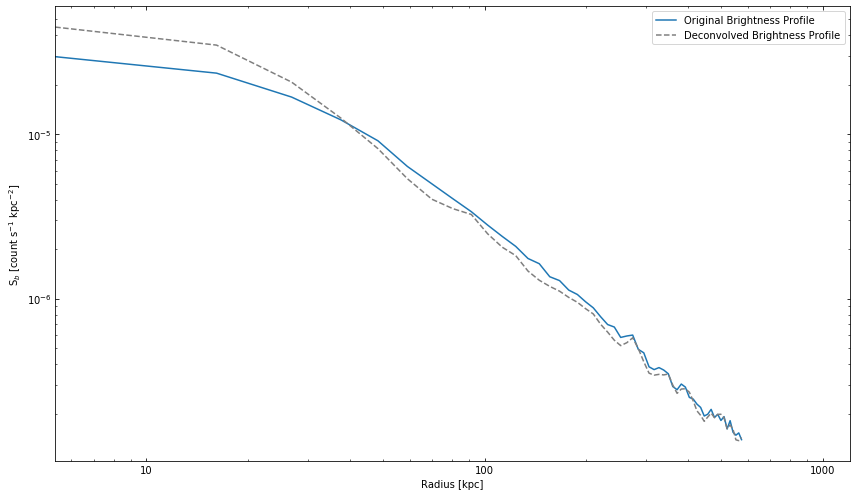

In [24]:
# Too much hassle to get a proper mask at this point, so just making a flat mask
# Means the background measurement is bollocks
flat_mask = np.ones(off_comb_rt.shape)

# Setup the figure
plt.figure(figsize=(12, 7))
ax = plt.gca()

# Centering at the original peak used to generate the PSFs
pix_loc = off_mos1_im.coord_conv(off_mos1_psf.ra_dec, pix)
# Getting the radial profile for the normal stacked ratemaps
brightness, br_err, radii, background, inn_r, out_r = radial_brightness(off_comb_rt, flat_mask, flat_mask, pix_loc,
                                                  Quantity(1000, 'kpc'), 0.13500871, 1, kpc)
brightness /= pix_kpc.value**2
plt.plot(radii, brightness, label="Original Brightness Profile", color="tab:blue")

# Getting the radial profile for the deconvolved stacked ratemaps
brightness, br_err, radii, background, inn_r, out_r = radial_brightness(off_comb_deconv_rt, flat_mask, flat_mask, pix_loc,
                                                  Quantity(1000, 'kpc'), 0.13500871, 1, kpc)
brightness /= pix_kpc.value**2

print(radii)

plt.plot(radii, brightness, label="Deconvolved Brightness Profile", color="tab:gray", linestyle="--")

# This adds small ticks to the axis
ax.minorticks_on()
# Adjusts how the ticks look
ax.tick_params(axis='both', direction='in', which='both', top=True, right=True)
# This would add a grid but I think it might look better without
# ax.grid(linestyle='dotted', linewidth=1)
# Choose y-axis log scaling because otherwise you can't really make out the profiles very well
ax.set_yscale("log")
ax.set_xscale('log')
ax.xaxis.set_major_formatter(ScalarFormatter())

# Set the lower limit of the x-axis to 0
ax.set_xlim(radii.min().value, 1200)
# Labels and legends
ax.set_ylabel("S$_{b}$ [count s$^{-1}$ kpc$^{-2}$]")
ax.set_xlabel("Radius [kpc]")
plt.legend(loc="best")
# Removes white space around the plot
plt.tight_layout()
# Plots the plot
plt.show()



# Was going to try simple convolution but probably not necessary

_Going to leave this here because the math looks pretty_

Lucas pointed out that I could just try the simple deconvolution route, using 

$\mathcal{F}[S + N]*\mathcal{F}[PSF] = \mathcal{F}[O]$,

where $\mathcal{F}$ denotes the fourier transform, S is the signal, N is the noise, and O is what is observed. The first step is to divide through by the PSF,

$\mathcal{F}[S + N] = \dfrac{\mathcal{F}[O]}{\mathcal{F}[PSF]}$.

Then you can take advantage of a property of fourier transforms,

$\mathcal{F}[A + B] = \mathcal{F}[A] + \mathcal{F}[B]$.

You end up with an expression for the fourier transform of the signal,

$\mathcal{F}[S] = \dfrac{\mathcal{F}[O]}{\mathcal{F}[PSF]} - \mathcal{F}[N]$.

**Though this does rely on having an estimate of the background, and I still don't know how valid these techniques are for extended sources.**